Notice: to run this notebook you need at least 40 gb memory. Since I used a 299 gb memory instance, I did not consider memory efficient coding.

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns


from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch 


In [2]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [3]:
from sklearn import preprocessing, model_selection, metrics

# Load Data

In [4]:
train_df = pd.read_csv("train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("test.csv", parse_dates=["activation_date"])

In [5]:
traindex = train_df.index
testdex = test_df.index

In [54]:
traindex

RangeIndex(start=0, stop=1503424, step=1)

# Explore Dataset

In [6]:
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [7]:
train_df.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim


### The train dataset description is as follows:

    item_id - Ad id.
    user_id - User id.
    region - Ad region.
    city - Ad city.
    parent_category_name - Top level ad category as classified by Avito's ad model.
    category_name - Fine grain ad category as classified by Avito's ad model.
    param_1 - Optional parameter from Avito's ad model.
    param_2 - Optional parameter from Avito's ad model.
    param_3 - Optional parameter from Avito's ad model.
    title - Ad title.
    description - Ad description.
    price - Ad price.
    item_seq_number - Ad sequential number for user.
    activation_date- Date ad was placed.
    user_type - User type.
    image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
    image_top_1 - Avito's classification code for the image.
    deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

Looks like we have no missing value. All columns are in correct data types.

Deal probability is our target variable and is a float value between 0 and 1. Price is the only "meaningful" numerical variable.


#### Destribution of deal_probability

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



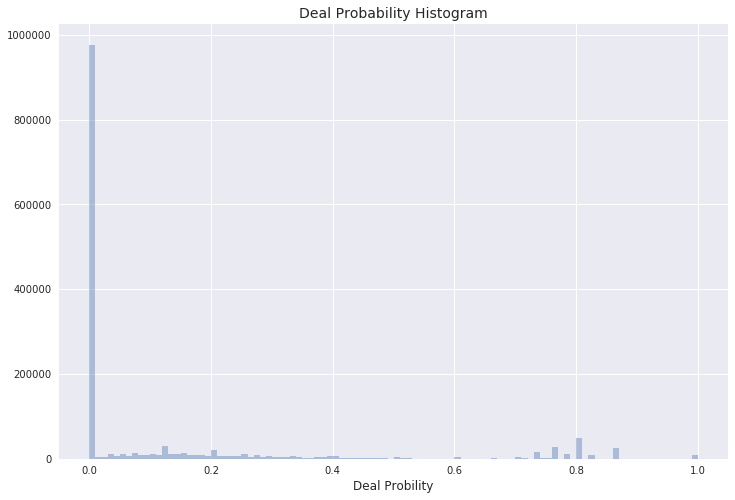

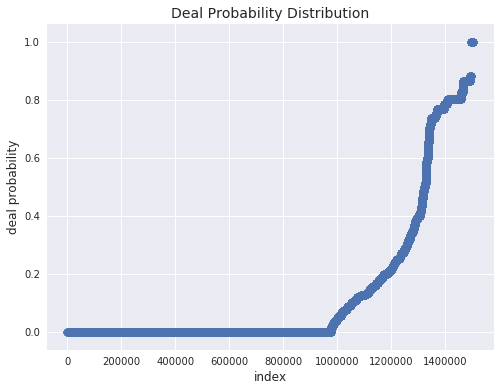

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

Almost 100K Ads has 0 probaility. Gamma distribution.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



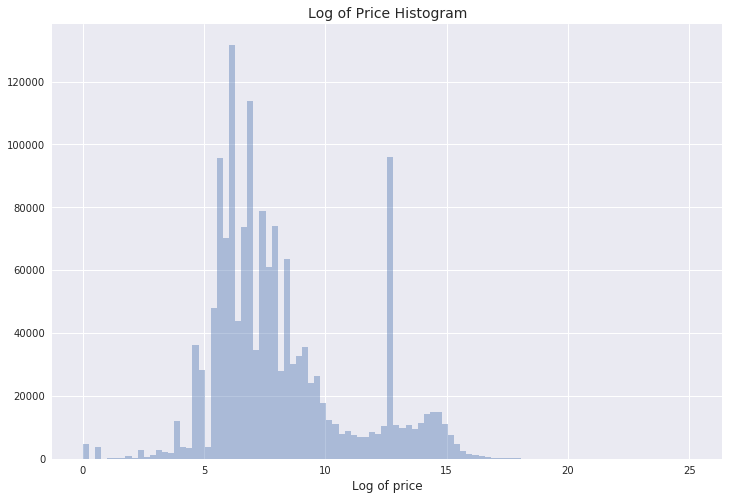

In [10]:
#Just in case, we still clean missing first. 
#For preventing leakage, we will delete the new column after showing the plot.
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

In [11]:
train_df = train_df.drop(["price_new"],axis =1 )
train_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789


Note that price is not normally distributed, so we look at the log transform of the price. 

In [12]:
#create new columns of word count for the title column.
train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
test_df["title_nwords"] = test_df["title"].apply(lambda x: len(x.split()))

In [13]:
#Plot word count for title column
cnt_srs = train_df['title_nwords'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords") 

Majority of the titles have under 5 words.

In [14]:
#create new columns of word count for the description column.
train_df["description"].fillna(" ", inplace=True)
test_df["description"].fillna(" ", inplace=True)
train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))
test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(x.split()))

In [15]:
# plot word count distribution for description column.
cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")  


In [16]:
train_df.activation_date.describe()

count                 1503424
unique                     21
top       2017-03-20 00:00:00
freq                   115190
first     2017-03-15 00:00:00
last      2017-04-07 00:00:00
Name: activation_date, dtype: object

The record period is between March and April 2017.

# Some data prep works

#### Combine train_df and test_df

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 20 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1503424 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
title_nwords   

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508438 entries, 0 to 508437
Data columns (total 19 columns):
item_id                 508438 non-null object
user_id                 508438 non-null object
region                  508438 non-null object
city                    508438 non-null object
parent_category_name    508438 non-null object
category_name           508438 non-null object
param_1                 485528 non-null object
param_2                 275209 non-null object
param_3                 202107 non-null object
title                   508438 non-null object
description             508438 non-null object
price                   477853 non-null float64
item_seq_number         508438 non-null int64
activation_date         508438 non-null datetime64[ns]
user_type               508438 non-null object
image                   465829 non-null object
image_top_1             465829 non-null float64
title_nwords            508438 non-null int64
desc_nwords             508438 non-

In [19]:
y = train_df['deal_probability'].copy()

In [20]:
y_df= pd.DataFrame(y)
y_df.head(10)

,deal_probability
0,0.12789
1,0.00000
2,0.43177
3,0.80323
4,0.20797
5,0.80323
6,0.00000
7,0.80323
8,0.00000
9,0.00000


### Checkpoint

In [22]:
train_df_copy = train_df.copy()

In [23]:
train_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,title_nwords,desc_nwords
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,3,7


In [24]:
train_df.drop("deal_probability",axis=1, inplace=True)

In [25]:
train_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,title_nwords,desc_nwords
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,3,7


# train_df_new
train_df_new = pd.concat([train_df,y_df], axis=1)

In [82]:
# Concat train and test data to full_df
full_df = pd.concat([train_df,test_df],axis=0)

In [84]:
full_df.shape

(2011862, 19)

In [85]:
full_df.tail(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,title_nwords,desc_nwords
508437,d374d332992f,ee74bccca74f,Воронежская область,Воронеж,Для дома и дачи,Ремонт и строительство,Инструменты,NaN,NaN,Лобзик Интерскол Мп-100э арт.18577,"Состояние: Хорошее/\n/\nКомплект: Кейс,пилка,ч...",1990.0,26463,2017-04-18,Shop,9c1ecc23ab04d543903bfd6a880d949fc1691cd7190dbb...,1255.0,4,72


Just in case, we still process the missing values cleaning steps.

In [86]:
for data in [full_df]:
    for column in ['param_1','param_2','param_3','image','image_top_1',"region", "city", "parent_category_name", "category_name", "user_type"]:
        data[column]=data[column].fillna(' ')

### Set target variable

Target and ID variables 
train_y = train["deal_probability"].values
valid_y = valid["deal_probability"].values
test_id = test["item_id"].values

# Feature engineering

In [87]:
# Create new variable on weekday #
for data in [full_df]:
    data['weekday'] = data.activation_date.dt.weekday
    data['month'] = data.activation_date.dt.month
    
    weekdaymap = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
    data['weekday_en'] = data['weekday'].apply(lambda x : weekdaymap[x])

In [88]:
full_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,item_seq_number,activation_date,user_type,image,image_top_1,title_nwords,desc_nwords,weekday,month,weekday_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,,,Кокоби(кокон для сна),...,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008,3,7,1,3,Mon


In [89]:
full_df = full_df.drop(['weekday'],axis = 1)

In [90]:
full_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price,item_seq_number,activation_date,user_type,image,image_top_1,title_nwords,desc_nwords,month,weekday_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,,,Кокоби(кокон для сна),...,400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008,3,7,3,Mon


In [91]:
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3","month","weekday_en"]
for col in cat_vars:
    full_df[col] = full_df[col].astype(str)


In [92]:
full_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price,item_seq_number,activation_date,user_type,image,image_top_1,title_nwords,desc_nwords,month,weekday_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,,,Кокоби(кокон для сна),...,400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008,3,7,3,Mon


Create lenght of param columns as new feature.

In [93]:
full_df['param_1_len'] = full_df['param_1'].apply(lambda x : len(x.split()))

In [94]:
full_df['param_2_len'] = full_df['param_2'].apply(lambda x : len(x.split()))

In [95]:
full_df['param_3_len'] = full_df['param_3'].apply(lambda x : len(x.split()))

In [96]:
# text preparation
full_df["txt"] = full_df["title"] + " " + full_df["description"] + " " + full_df["param_1"] + " " + full_df["param_2"] + " " + full_df["param_3"]

In [97]:
# lower everything
full_df["txt"] = full_df["txt"].str.lower() 

In [98]:
# remove punctuation
full_df["txt"] = full_df["txt"].str.replace('[^\w\s]',' ')

# You may want to install this package


import nltk
nltk.download("stopwords")

In [100]:
# remove stopwords
stop_words = stopwords.words('russian')
rs = RussianStemmer()

In [101]:
# remove stopwords
full_df["txt"] = full_df["txt"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [102]:
# create lenght
full_df['txt_len'] = full_df["txt"].apply(lambda x : len(x.split()))

In [103]:
#drop useless columns
full_df.drop(["activation_date", "title", "description", "param_1","param_2", "param_3","image"], axis = 1, inplace = True)

In [104]:
full_df.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,title_nwords,desc_nwords,month,weekday_en,param_1_len,param_2_len,param_3_len,txt,txt_len
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,400.0,2,Private,1008,3,7,3,Mon,2,0,0,кокоби кокон сна кокон сна малыша пользовались...,13


# Split data into trainvalid and test

In [105]:
trainvalid = full_df.iloc[traindex,:].copy()
print("Train Set shape",trainvalid.shape)
test = full_df.iloc[testdex,:].copy()
print("test Set Shape: {} Rows, {} Columns".format(*test.shape))

Train Set shape (1503424, 19)
test Set Shape: 508438 Rows, 19 Columns


In [139]:
trainvalid.tail()

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,title_nwords,desc_nwords,month,weekday_en,param_1_len,param_2_len,param_3_len,txt,txt_len
1503419,5e6b7f0f3f65,dd05217165ea,Пермский край,Пермь,Личные вещи,Детская одежда и обувь,300.0,7,Private,88,1,0,3,Sun,2,1,1,ботиночки девочек обувь 26,4
1503420,d1f0910d2126,dc23ef451c8a,Краснодарский край,Краснодар,Услуги,Предложение услуг,200.0,1,Private,1191,2,34,3,Mon,2,2,0,натяжной потолок произведем бесплатный замер изготовим установим н...,31
1503421,bc04866bc803,66a7016a5995,Башкортостан,Белебей,Недвижимость,Квартиры,NaN,50,Company,1202,6,27,3,Mon,1,1,1,4 квартира 83 м² 4 5 эт продам квартиру отличным ремонтом две лодж...,34
1503422,f782f2ad9349,2d3ac1f5a7b3,Пермский край,Березники,Личные вещи,Детская одежда и обувь,350.0,33,Private,87,1,6,3,Tue,2,1,1,туфли балетки продам красивые туфли хорошем состоянии девочек обув...,10
1503423,9ad3b7bff1db,f3342ccd95c8,Краснодарский край,Анапа,Личные вещи,Товары для детей и игрушки,1500.0,18,Private,979,7,145,3,Mon,1,0,0,кукольные домики берез фанеры большой выбор предлагаем вашему вним...,115


In [140]:
test.head()

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,-0.068171,-0.133625,Private,1008,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,11.449311,-0.222978,-0.116163,-0.233464,-0.213895
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,-0.067486,-0.130551,Private,692,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,-0.067223,-0.132359,Private,3032,...,-0.132376,-0.122316,-0.168988,-0.175422,4.829672,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,-0.067697,-0.082265,Company,796,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,-0.057741,-0.133444,Private,2264,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895


In [106]:
fulltrainvalid = pd.concat([trainvalid,y_df],axis=1)

In [107]:
fulltrainvalid.tail(3)

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,title_nwords,desc_nwords,month,weekday_en,param_1_len,param_2_len,param_3_len,txt,txt_len,deal_probability
1503421,bc04866bc803,66a7016a5995,Башкортостан,Белебей,Недвижимость,Квартиры,NaN,50,Company,1202,6,27,3,Mon,1,1,1,4 квартира 83 м² 4 5 эт продам квартиру отличн...,34,0.39569
1503422,f782f2ad9349,2d3ac1f5a7b3,Пермский край,Березники,Личные вещи,Детская одежда и обувь,350.0,33,Private,87,1,6,3,Tue,2,1,1,туфли балетки продам красивые туфли хорошем со...,10,0.00000
1503423,9ad3b7bff1db,f3342ccd95c8,Краснодарский край,Анапа,Личные вещи,Товары для детей и игрушки,1500.0,18,Private,979,7,145,3,Mon,1,0,0,кукольные домики берез фанеры большой выбор пр...,115,0.00000


In [108]:
train, valid= train_test_split( fulltrainvalid, test_size=0.3,random_state=123)

# Check point

In [109]:
train_play = train
valid_play = valid
test_play = test

# TFIDF

In [110]:
for data in [train_play,valid_play,test_play]:
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_train = np.array(tfidf.fit_transform(data['txt']).todense(), dtype=np.float16)
    for i in range(100):
        data['tfidf_' + str(i)] = tfidf_train[:, i]

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [111]:
train_play.head(1)

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
1146931,011e5ee70614,56db645b99a8,Нижегородская область,Нижний Новгород,Личные вещи,"Одежда, обувь, аксессуары",1800.0,41,Company,515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Standardize numerical variables

In [112]:
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numc = train_play.select_dtypes(include=numerics).columns
numc

Index(['price', 'item_seq_number', 'title_nwords', 'desc_nwords',
       'param_1_len', 'param_2_len', 'param_3_len', 'txt_len',
       'deal_probability', 'tfidf_0',
       ...
       'tfidf_90', 'tfidf_91', 'tfidf_92', 'tfidf_93', 'tfidf_94', 'tfidf_95',
       'tfidf_96', 'tfidf_97', 'tfidf_98', 'tfidf_99'],
      dtype='object', length=109)

In [113]:
to_std=list(set(numc)-set(["deal_probability"]))
len(to_std)

108

In [114]:
for data in [train_play,valid_play,test_play]:
    data[to_std] =(data[to_std] - data[to_std].mean())/data[to_std].std()

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [115]:
train_play.drop(["txt"],axis =1)
valid_play.drop(["txt"],axis =1)
test_play.drop(["txt"],axis =1)

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,-0.068171,-0.133625,Private,1008,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,11.449311,-0.222978,-0.116163,-0.233464,-0.213895
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,-0.067486,-0.130551,Private,692,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,-0.067223,-0.132359,Private,3032,...,-0.132376,-0.122316,-0.168988,-0.175422,4.829672,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,-0.067697,-0.082265,Company,796,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,-0.057741,-0.133444,Private,2264,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,-0.067934,-0.132359,Private,796,...,-0.132376,-0.122316,-0.168988,-0.175422,6.317728,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,-0.065379,-0.111381,Private,2823,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",-0.068145,-0.122955,Private,567,...,-0.132376,-0.122316,-0.168988,-0.175422,3.475418,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",-0.068145,-0.118615,Private,415,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,5.502270
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,-0.068171,-0.109392,Company,46,...,-0.132376,-0.122316,5.047077,-0.175422,-0.267024,5.261714,-0.222978,-0.116163,-0.233464,-0.213895


# Start H2o For modelling Part

In [116]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,24 mins 56 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_ec2_user_bfv104
H2O cluster total nodes:,1
H2O cluster free memory:,23.43 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"locked, healthy"


# AutoML

In [117]:
from h2o.automl import H2OAutoML

#### Just to make sure we have everything we needed in the three datasets.

In [118]:
train_play.head()

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
1146931,011e5ee70614,56db645b99a8,Нижегородская область,Нижний Новгород,Личные вещи,"Одежда, обувь, аксессуары",-0.004214,-0.125969,Company,515,...,-0.131916,-0.122504,-0.168768,-0.174643,-0.267363,-0.186019,-0.223791,-0.115884,-0.234520,-0.214242
439935,baa9d906d3f8,bc235c0f9391,Омская область,Омск,Для бизнеса,Оборудование для бизнеса,-0.004174,-0.133122,Private,2801,...,-0.131916,-0.122504,-0.168768,-0.174643,-0.267363,-0.186019,-0.223791,-0.115884,-0.234520,-0.214242
1408103,ef79723444f3,f3ec3245f367,Краснодарский край,Сочи,Хобби и отдых,Спорт и отдых,-0.004224,-0.123466,Company,2218,...,-0.131916,-0.122504,-0.168768,-0.174643,-0.267363,-0.186019,-0.223791,-0.115884,-0.234520,-0.214242
215627,623b59135ec7,53a76e6553c1,Воронежская область,Воронеж,Личные вещи,Товары для детей и игрушки,-0.004206,-0.132407,Private,1002,...,-0.131916,-0.122504,-0.168768,-0.174643,4.457477,-0.186019,-0.223791,-0.115884,-0.234520,-0.214242
1139496,c810ca5cedc9,ec6f5e4fed0e,Ставропольский край,Кисловодск,Недвижимость,Квартиры,-0.004049,-0.116670,Company,,...,-0.131916,-0.122504,-0.168768,-0.174643,-0.267363,-0.186019,-0.223791,-0.115884,3.253363,-0.214242


In [119]:

valid_play.head()

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
1023544,89a03cdb62c3,19d5ebd985c8,Красноярский край,Сухобузимское,Недвижимость,"Дома, дачи, коттеджи",0.049863,0.200007,Company,,...,3.928450,-0.122148,-0.169309,-0.176379,1.029183,-0.185689,-0.222917,-0.115163,-0.234369,-0.213584
1308125,b19c7b1221b4,1cbaba57bb47,Тюменская область,Тюмень,Личные вещи,"Одежда, обувь, аксессуары",-0.056560,-0.122241,Private,92,...,-0.132779,-0.122148,-0.169309,5.119841,-0.266958,-0.185689,-0.222917,-0.115163,-0.234369,-0.213584
370910,a9531307bfb5,b804ce65a7c7,Ярославская область,Рыбинск,Для дома и дачи,Мебель и интерьер,-0.056251,-0.130745,Private,1417,...,-0.132779,-0.122148,-0.169309,-0.176379,6.276237,-0.185689,-0.222917,-0.115163,-0.234369,-0.213584
633906,ea75ef7aac9d,1a90babf82a7,Калининградская область,Калининград,Недвижимость,Комнаты,0.081812,-0.126764,Private,,...,-0.132779,-0.122148,-0.169309,-0.176379,-0.266958,-0.185689,-0.222917,-0.115163,9.054032,-0.213584
560985,8e0368bccf5f,8814aaea0ada,Тюменская область,Тюмень,Личные вещи,Товары для детей и игрушки,-0.056592,-0.119708,Private,1020,...,-0.132779,-0.122148,-0.169309,-0.176379,-0.266958,-0.185689,-0.222917,-0.115163,-0.234369,-0.213584


In [120]:

test_play.head()

,item_id,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,-0.068171,-0.133625,Private,1008,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,11.449311,-0.222978,-0.116163,-0.233464,-0.213895
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,-0.067486,-0.130551,Private,692,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,-0.067223,-0.132359,Private,3032,...,-0.132376,-0.122316,-0.168988,-0.175422,4.829672,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,-0.067697,-0.082265,Company,796,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,-0.057741,-0.133444,Private,2264,...,-0.132376,-0.122316,-0.168988,-0.175422,-0.267024,-0.187235,-0.222978,-0.116163,-0.233464,-0.213895


In [123]:
y = 'deal_probability'
x = [name for name in train_play.columns if name not in [y]]

h2o_train_df = h2o.H2OFrame(train_play)
h2o_valid_df = h2o.H2OFrame(valid_play)
test_final = h2o.H2OFrame(test_play)

aml = H2OAutoML(max_runtime_secs = 300)
aml.train(x = x, y = y,
          training_frame = h2o_train_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [124]:
lb = aml.leaderboard
lb

model_id,mean_residual_deviance,rmse,mae,rmsle
DRF_0_AutoML_20180629_234247,0.0536026,0.231522,0.155689,0.172512


In [125]:
aml.leader

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_0_AutoML_20180629_234247


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.05427545202381584
RMSE: 0.2329709252757001
MAE: 0.156032806594157
RMSLE: 0.17377480847651128
Mean Residual Deviance: 0.05427545202381584

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.05382998290494475
RMSE: 0.23201289383339183
MAE: 0.15615351892709464
RMSLE: 0.1728111602333346
Mean Residual Deviance: 0.05382998290494475

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.053602628301266955
RMSE: 0.2315224142524152
MAE: 0.15568854352102574
RMSLE: 0.17251151912381046
Mean Residual Deviance: 0.053602628301266955
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.1556885,0.0001823,0.1554470,0.1556053,0.1561820,0.1555361,0.1556723
mean_residual_deviance,0.0536026,0.0002080,0.0531918,0.0534831,0.0540807,0.0535296,0.0537279
mse,0.0536026,0.0002080,0.0531918,0.0534831,0.0540807,0.0535296,0.0537279
r2,0.2069799,0.0018402,0.2091815,0.2105586,0.2037585,0.2045696,0.2068314
residual_deviance,0.0536026,0.0002080,0.0531918,0.0534831,0.0540807,0.0535296,0.0537279
rmse,0.2315215,0.0004490,0.2306335,0.2312641,0.2325525,0.2313647,0.2317929
rmsle,0.1725111,0.0002769,0.1719765,0.1723149,0.1731657,0.1724757,0.1726227


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-30 00:08:22,25 min 29.046 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-30 00:08:33,25 min 40.443 sec,1.0,0.2585356,0.1627480,0.0668407,0.2594416,0.1634567,0.0673100
,2018-06-30 00:08:43,25 min 50.550 sec,2.0,0.2546925,0.1619542,0.0648683,0.2454282,0.1603359,0.0602350
,2018-06-30 00:08:53,26 min 0.251 sec,3.0,0.2516860,0.1612380,0.0633459,0.2405707,0.1588786,0.0578743
,2018-06-30 00:09:03,26 min 10.420 sec,4.0,0.2494136,0.1605379,0.0622072,0.2383222,0.1582504,0.0567975
---,---,---,---,---,---,---,---,---,---
,2018-06-30 00:12:58,30 min 4.987 sec,26.0,0.2335212,0.1562367,0.0545322,0.2322183,0.1562378,0.0539254
,2018-06-30 00:13:09,30 min 16.776 sec,27.0,0.2333433,0.1561489,0.0544491,0.2321296,0.1561861,0.0538842
,2018-06-30 00:13:21,30 min 28.638 sec,28.0,0.2332102,0.1561004,0.0543870,0.2320652,0.1561566,0.0538542
,2018-06-30 00:13:31,30 min 37.999 sec,29.0,0.2330861,0.1560660,0.0543291,0.2320492,0.1561625,0.0538469



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
category_name,76779.9140625,1.0,0.1651274
image_top_1,62088.1835938,0.8086514,0.1335305
region,42078.1757812,0.5480362,0.0904958
parent_category_name,41859.4101562,0.5451870,0.0900253
weekday_en,18003.3457031,0.2344799,0.0387191
---,---,---,---
tfidf_20,185.6356812,0.0024178,0.0003992
tfidf_91,182.8391876,0.0023813,0.0003932
tfidf_65,146.8307495,0.0019124,0.0003158
tfidf_99,120.4891968,0.0015693,0.0002591



See the whole table with table.as_data_frame()


In [126]:
preds = aml.leader.predict(test_final)

drf prediction progress: |████████████████████████████████████████████████| 100%


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'city' has levels not trained on: [Верхняя Тишанка, Исток, Канашево, Ленина, Мама, Никольское, Отказное, Перелешинский, Правокумское, Придонский, Роговатое, Садовое]



In [127]:
preds.tail()

predict
0.149964
0.120887
0.0631781
0.197909
0.120298
0.280673
0.220485
0.173463
0.216291
0.0711123


# Generate Submission File

In [137]:
test_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,title_nwords,desc_nwords
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386bd5e32262735e68512,2020.0,2,2
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состоянии.Все вопросы по ...",3000.0,4,2017-04-16,Private,NaN,NaN,2,10
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт ТВ Wi-Fi приложения...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c9428bf86da6d04eb6b7d5,2960.0,1,21
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами.Модель Jetair Tina p...",4500.0,70,2017-04-17,Private,NaN,NaN,3,12
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопросы по телефону.,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8fd15f8183be44dc701c,1002.0,2,10


In [128]:
import re
#import time

def gen_submission(preds,name,test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    #time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    #sub = test_new['item_id'].cbind(preds)
    result = preds.as_data_frame()
    sub = pd.concat([test_play['item_id'],result['predict']], axis = 1)
    sub.columns = ['item_id', 'deal_probability']
    sub['item_id']=sub['item_id'].astype('str')
    
    # save file for submission
    sub_fname =  str(name) + '.csv'
    sub.to_csv(sub_fname,index=False)

In [129]:
gen_submission(preds,"automl_pred")

# Check the submission file

In [130]:
autopreds = pd.read_csv("automl_pred.csv")

In [131]:
autopreds.tail()

,item_id,deal_probability
508433,3431a3103256,0.280673
508434,79a53d20a439,0.220485
508435,ec5d1844684e,0.173463
508436,68b8e2f6ae6d,0.216291
508437,06e6a674fecf,0.071112


In [132]:
autopreds.shape

(508438, 2)

In [ ]:
#Just for remember, output dataframe to csv using following code:
#valid1.to_csv("valid1.csv",sep=",",index=False)

# GLM

In [133]:
alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
grid = H2OGridSearch(H2OGeneralizedLinearEstimator(
            family="gaussian",
            nfolds=5,
            keep_cross_validation_predictions=True,
            lambda_search=True,
            seed=123),
            hyper_params=hyper_parameters)
    # train grid
grid.train(y=y,
           x=x, 
           training_frame=h2o_train_df,
           validation_frame=h2o_valid_df)
# show grid search results
grid.show()

# select best model
glm_model = grid.get_grid()[0]

# print model information
glm_model

glm_preds1_test = glm_model.predict(test_final)
gen_submission(glm_preds1_test,"glm")



glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha  \
0    [0.99]   
1     [0.5]   
2    [0.25]   
3    [0.01]   

                                                               model_ids  \
0  Grid_GLM_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   
1  Grid_GLM_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   
2  Grid_GLM_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   
3  Grid_GLM_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   

   residual_deviance  
0  61644.15706558984  
1  61684.21207604292  
2  61751.78416355868  
3  63138.20065511951  
glm prediction progress: |████████████████████████████████████████████████| 100%


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'city' has levels not trained on: [Верхняя Тишанка, Исток, Канашево, Ленина, Мама, Никольское, Отказное, Перелешинский, Правокумское, Придонский, Роговатое, Садовое]



In [135]:
glmmm = pd.read_csv("glm.csv")
glmmm.head()

,item_id,deal_probability
0,b912c3c6a6ad,0.147364
1,2dac0150717d,0.092542
2,ba83aefab5dc,0.296444
3,02996f1dd2ea,0.161873
4,7c90be56d2ab,0.371726


# Random forest

In [141]:
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    balance_classes = True,
    nfolds=5,
    keep_cross_validation_predictions=True,
    seed = 123)

hyper_parameters = {'ntrees':list(range(0, 600, 20)),
                    'max_depth':list(range(1, 30, 3))}

            
# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':300,
                   "stopping_rounds": 10,
                   "stopping_tolerance": 0.00001,
                   "stopping_metric": "auto"}
  

gsearch = H2OGridSearch(estimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)


    
gsearch.train(x=x,
              y=y,
              training_frame=h2o_train_df,
              validation_frame=h2o_valid_df)

# show grid search results
gsearch.show()

# select best model
rf_model = gsearch.get_grid()[0]

# print model information
rf_model

rf_preds1_test = rf_model.predict(test_final)
gen_submission(rf_preds1_test,"rf")

drf Grid Build progress: |████████████████████████████████████████████████| 100%
    max_depth ntrees  \
0          10     36   
1          28      1   

                                                               model_ids  \
0  Grid_DRF_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   
1  Grid_DRF_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   

     residual_deviance  
0  0.05521635935160006  
1  0.08419283990508983  
drf prediction progress: |████████████████████████████████████████████████| 100%


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'city' has levels not trained on: [Верхняя Тишанка, Исток, Канашево, Ленина, Мама, Никольское, Отказное, Перелешинский, Правокумское, Придонский, Роговатое, Садовое]



In [142]:
rfff = pd.read_csv("rf.csv")
rfff.tail()

,item_id,deal_probability
508433,3431a3103256,0.232201
508434,79a53d20a439,0.265008
508435,ec5d1844684e,0.110654
508436,68b8e2f6ae6d,0.188395
508437,06e6a674fecf,0.063790


# Neural Network

In [143]:
# define random grid search parameters
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':300}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator(nfolds=5,
                                                 keep_cross_validation_predictions=True,
                                                 seed = 123),
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=x,
              y=y,
              training_frame=h2o_train_df,
              validation_frame=h2o_valid_df)

# show grid search results
gsearch.show()

# select best model
nn_model = gsearch.get_grid()[0]

# print model information
nn_model

nn_preds1_test = nn_model.predict(test_final)
gen_submission(nn_preds1_test,'neuralnet')

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
    hidden input_dropout_ratio   l1     l2  \
0    [100]                0.08  0.0  0.007   

                                                               model_ids  \
0  Grid_DeepLearning_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42...   

     residual_deviance  
0  0.05675156000759675  
deeplearning prediction progress: |███████████████████████████████████████| 100%


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'city' has levels not trained on: [Верхняя Тишанка, Исток, Канашево, Ленина, Мама, Никольское, Отказное, Перелешинский, Правокумское, Придонский, Роговатое, Садовое]



In [144]:
neuralnnn = pd.read_csv("neuralnet.csv")
neuralnnn.tail()

,item_id,deal_probability
508433,3431a3103256,0.212664
508434,79a53d20a439,0.244950
508435,ec5d1844684e,0.073620
508436,68b8e2f6ae6d,0.137352
508437,06e6a674fecf,0.059618


# GBM

In [145]:
hyper_parameters = {'ntrees':list(range(0, 600, 20)),
                    'max_depth':list(range(1, 30, 3)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':300}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator(
                        nfolds=5,
                        keep_cross_validation_predictions=True,
                        seed = 123),
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)
gsearch.train(x=x,
              y=y,
              training_frame =h2o_train_df,
              validation_frame =h2o_valid_df)

# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model

gbm_preds1_test = gbm_model.predict(test_final)
gen_submission(gbm_preds1_test,"gbm_preds1")

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate max_depth ntrees sample_rate  \
0               0.3         4    221         0.8   

                                                               model_ids  \
0  Grid_GBM_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   

     residual_deviance  
0  0.05470076462796619  
gbm prediction progress: |████████████████████████████████████████████████| 100%


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'city' has levels not trained on: [Верхняя Тишанка, Исток, Канашево, Ленина, Мама, Никольское, Отказное, Перелешинский, Правокумское, Придонский, Роговатое, Садовое]



In [146]:
gbmmm = pd.read_csv("gbm_preds1.csv")
gbmmm.tail()

,item_id,deal_probability
508433,3431a3103256,0.238302
508434,79a53d20a439,0.278796
508435,ec5d1844684e,0.089517
508436,68b8e2f6ae6d,0.203515
508437,06e6a674fecf,0.076270


In [147]:
gbm_preds1_test.tail()

predict
0.167071
0.164768
0.072767
0.168843
0.157877
0.238302
0.278796
0.089517
0.203515
0.0762702


In [148]:
test_final.shape

(508438, 119)

# ERT

In [150]:
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    balance_classes = True,
    nfolds=5,
    keep_cross_validation_predictions=True,
    seed = 123,
    histogram_type='random')

hyper_parameters = {'ntrees':list(range(0, 600, 20)),
                    'max_depth':list(range(1, 30, 3))}

            
# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':300,
                   "stopping_rounds": 10,
                   "stopping_tolerance": 0.00001,
                   "stopping_metric": "auto"}
  

gsearch = H2OGridSearch(estimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)


    
gsearch.train(x=x,
              y=y,
              training_frame=h2o_train_df,
              validation_frame=h2o_valid_df)

# show grid search results
gsearch.show()

# select best model
ert_model = gsearch.get_grid()[0]

# print model information
ert_model

ert_preds1_test = ert_model.predict(test_final)
gen_submission(ert_preds1_test,'ert')

drf Grid Build progress: |████████████████████████████████████████████████| 100%
    max_depth ntrees  \
0          10     15   
1          10     31   

                                                               model_ids  \
0  Grid_DRF_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   
1  Grid_DRF_Key_Frame__upload_92a8602a1b4a8110de95a1a20e3b42a4.hex_mo...   

     residual_deviance  
0  0.05648411762158477  
1  0.05653643444516842  
drf prediction progress: |████████████████████████████████████████████████| 100%


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'city' has levels not trained on: [Верхняя Тишанка, Исток, Канашево, Ленина, Мама, Никольское, Отказное, Перелешинский, Правокумское, Придонский, Роговатое, Садовое]



# xgboost

In [152]:
estimator = H2OXGBoostEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    nfolds=5,
    keep_cross_validation_predictions=True,
    seed = 123)

hyper_parameters = {'ntrees':list(range(0, 600, 20)),
                    'max_depth':list(range(1, 30, 3))}

            
# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':300,
                   "stopping_rounds": 10,
                   "stopping_tolerance": 0.00001,
                   "stopping_metric": "auto"}
  

gsearch = H2OGridSearch(estimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

    
gsearch.train(x=x,
              y=y,
              training_frame=h2o_train_df,
              validation_frame=h2o_valid_df)

# show grid search results
gsearch.show()

# select best model
xgb_model = gsearch.get_grid()[0]

# print model information
xgb_model

xgb = xgb_model.predict(test_final)
gen_submission(xgb,'xgb')

xgboost Grid Build progress: |███ (failed)


OSError: Job with key $03017f00000132d4ffffffff$_a3821ee27922333d914b36f6b5fc4c62 failed with an exception: java.lang.OutOfMemoryError: Java heap space
stacktrace: 
java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3356)
	at hex.tree.xgboost.XGBoostUtils.enlargeFloatTable(XGBoostUtils.java:763)
	at hex.tree.xgboost.XGBoostUtils.denseChunk(XGBoostUtils.java:334)
	at hex.tree.xgboost.XGBoostUtils.convertFrameToDMatrix(XGBoostUtils.java:115)
	at ml.dmlc.xgboost4j.java.XGBoostSetupTask.makeLocalMatrix(XGBoostSetupTask.java:55)
	at ml.dmlc.xgboost4j.java.XGBoostSetupTask.setupLocal(XGBoostSetupTask.java:42)
	at water.MRTask.setupLocal0(MRTask.java:550)
	at water.MRTask.dfork(MRTask.java:456)
	at water.MRTask.doAll(MRTask.java:389)
	at water.MRTask.doAll(MRTask.java:385)
	at hex.tree.xgboost.XGBoost$XGBoostDriver.buildModelImpl(XGBoost.java:316)
	at hex.tree.xgboost.XGBoost$XGBoostDriver.buildModel(XGBoost.java:262)
	at hex.tree.xgboost.XGBoost$XGBoostDriver.computeImpl(XGBoost.java:252)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:214)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1249)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


# Stacking Model

This is the code for stacking models. I haven't tried it.

In [ ]:
stack = H2OStackedEnsembleEstimator(training_frame=train_s, 
                                    validation_frame=valid_s, 
                                    base_models=[glm_model,rf_model, ert_model, 
                                                 gbm_model,xgb_model,nn_model])

stack.train(x=X,
            y=y,
            training_frame=train_s,
            validation_frame=valid_s)




In [ ]:
stack_preds1_test = stack.predict(test_final)
gen_submission(stack_preds1_test)

In [ ]:
h2o.cluster().shutdown(prompt=False)
